# Load data

In [13]:
from scipy.io import loadmat

data = loadmat("concatenated_1000ms_from250_speed10_bin100.mat")
features = data["features"]
position = data["position"]

print features.shape, position.shape

(12600L, 76L) (12600L, 2L)


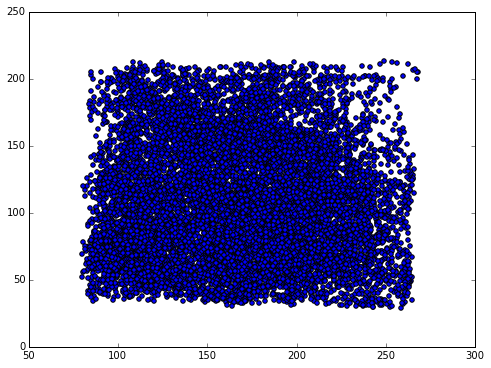

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(position[...,0], position[...,1])

# Split into training and test set

Currently using first 80% as training and last 20% as test (actually validation) set.

In [15]:
nr_samples = features.shape[0]
nr_train = int(0.8 * nr_samples)
nr_test = nr_samples - nr_train

train_X = features[:nr_train]
train_Y = position[:nr_train]
test_X = features[nr_train:]
test_Y = position[nr_train:]

print train_X.shape, train_Y.shape, test_X.shape, test_Y.shape

(10080L, 76L) (10080L, 2L) (2520L, 76L) (2520L, 2L)


# Helper function to calculate mean distance

In [16]:
def mean_distance(pred_Y, test_Y):
    return np.mean(np.sqrt(np.sum((pred_Y - test_Y) ** 2, axis=1)))

# Linear regression

Result is as expected. Model does not overfit.

In [24]:
from sklearn.linear_model import LinearRegression
import numpy as np

lm = LinearRegression()
lm.fit(train_X, train_Y)
train_pred_Y = lm.predict(train_X)
test_pred_Y = lm.predict(test_X)

print "Train mean distance %f, test mean distance: %f" % \
    (mean_distance(train_pred_Y, train_Y), mean_distance(test_pred_Y, test_Y))

Train mean distance 38.647073, test mean distance: 36.446996


# Random forest

## First take with default parameters

The result is better than with linear model. Overfitting is a problem.

In [42]:
from sklearn.ensemble.forest import RandomForestRegressor
rf = RandomForestRegressor()
rf.fit(train_X, train_Y)
train_pred_Y = rf.predict(train_X)
test_pred_Y = rf.predict(test_X)

print "Train mean distance %f, test mean distance: %f, test R^2 score %f" % \
    (mean_distance(train_pred_Y, train_Y), mean_distance(test_pred_Y, test_Y), rf.score(test_X, test_Y))

Train mean distance 8.042994, test mean distance: 27.309060, test R^2 score 0.628890


## Try more trees

More trees improves result, but overfitting is still a problem. 100 seems optimal for further testing.

In [43]:
for n in [10, 100, 1000]:
    rf = RandomForestRegressor(n_estimators = n)
    rf.fit(train_X, train_Y)
    train_pred_Y = rf.predict(train_X)
    test_pred_Y = rf.predict(test_X)

    print "Train mean distance %f, test mean distance: %f, test R^2 score %f" % \
        (mean_distance(train_pred_Y, train_Y), mean_distance(test_pred_Y, test_Y), rf.score(test_X, test_Y))

Train mean distance 7.905999, test mean distance: 27.188677, test R^2 score 0.633448
Train mean distance 6.793925, test mean distance: 25.158810, test R^2 score 0.688074
Train mean distance 6.630572, test mean distance: 25.077061, test R^2 score 0.687507


## Reduce number of features

Using random half of the features for splitting seems to work best.

In [44]:
for features in [0.5, "sqrt", "log2"]:
    rf = RandomForestRegressor(n_estimators = 100, max_features = features)
    rf.fit(train_X, train_Y)
    train_pred_Y = rf.predict(train_X)
    test_pred_Y = rf.predict(test_X)

    print "Train mean distance %f, test mean distance: %f, test R^2 score %f" % \
        (mean_distance(train_pred_Y, train_Y), mean_distance(test_pred_Y, test_Y), rf.score(test_X, test_Y))

Train mean distance 6.812691, test mean distance: 25.065711, test R^2 score 0.700867
Train mean distance 7.327412, test mean distance: 26.714456, test R^2 score 0.689453
Train mean distance 7.592474, test mean distance: 27.430455, test R^2 score 0.681918


## Reduce tree depth

Reduces overfitting, at the expense of worse performance on test set.

In [50]:
for depth in [10, 20, 30]:
    rf = RandomForestRegressor(n_estimators = 100, max_features = 0.5, max_depth = depth)
    rf.fit(train_X, train_Y)
    train_pred_Y = rf.predict(train_X)
    test_pred_Y = rf.predict(test_X)

    print "Train mean distance %f, test mean distance: %f, test R^2 score %f" % \
        (mean_distance(train_pred_Y, train_Y), mean_distance(test_pred_Y, test_Y), rf.score(test_X, test_Y))

Train mean distance 30.344353, test mean distance: 32.594951, test R^2 score 0.553519
Train mean distance 12.605079, test mean distance: 25.758595, test R^2 score 0.686660
Train mean distance 7.406043, test mean distance: 24.875514, test R^2 score 0.703662


## Limit number of leaf nodes

In [51]:
for leaf in [100, 500, 1000]:
    rf = RandomForestRegressor(n_estimators = 100, max_features = 0.5, max_leaf_nodes = leaf)
    rf.fit(train_X, train_Y)
    train_pred_Y = rf.predict(train_X)
    test_pred_Y = rf.predict(test_X)

    print "Train mean distance %f, test mean distance: %f, test R^2 score %f" % \
        (mean_distance(train_pred_Y, train_Y), mean_distance(test_pred_Y, test_Y), rf.score(test_X, test_Y))

Train mean distance 29.819178, test mean distance: 31.188427, test R^2 score 0.594309
Train mean distance 17.295825, test mean distance: 26.506441, test R^2 score 0.680558
Train mean distance 11.935541, test mean distance: 25.299904, test R^2 score 0.699971


## The best result

In [54]:
rf = RandomForestRegressor(n_estimators = 100, max_features = 0.5)
rf.fit(train_X, train_Y)
train_pred_Y = rf.predict(train_X)
test_pred_Y = rf.predict(test_X)

print "Train mean distance %f, test mean distance: %f, test R^2 score %f" % \
    (mean_distance(train_pred_Y, train_Y), mean_distance(test_pred_Y, test_Y), rf.score(test_X, test_Y))

Train mean distance 6.756804, test mean distance: 24.888013, test R^2 score 0.703622


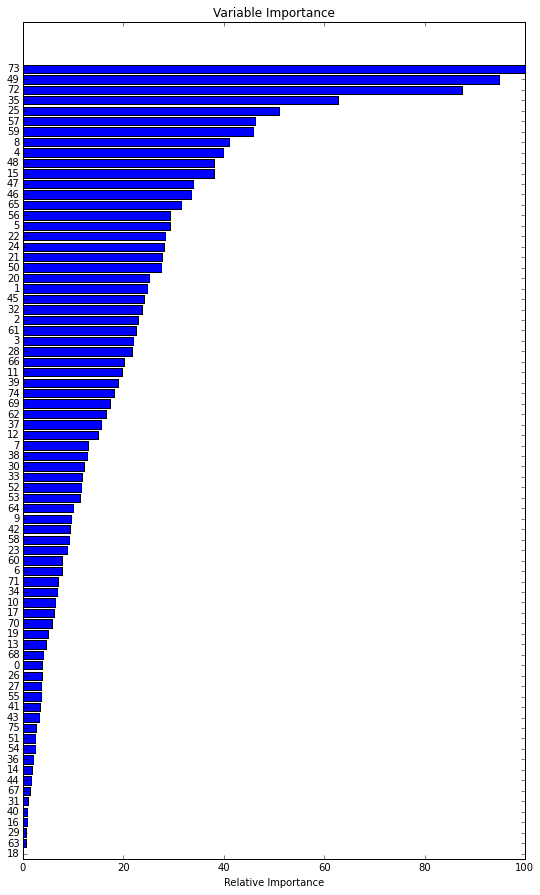

In [119]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot feature importance
feature_importance = rf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(9,15))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, sorted_idx)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

# Extremely randomized trees

Worked slightly better with default parameters, but no major leap.

In [59]:
from sklearn.ensemble import ExtraTreesRegressor

et = ExtraTreesRegressor(n_estimators = 100)
et.fit(train_X, train_Y)
train_pred_Y = et.predict(train_X)
test_pred_Y = et.predict(test_X)

print "Train mean distance %f, test mean distance: %f, test R^2 score %f" % \
    (mean_distance(train_pred_Y, train_Y), mean_distance(test_pred_Y, test_Y), et.score(test_X, test_Y))

Train mean distance 0.000000, test mean distance: 24.523309, test R^2 score 0.715114


In [25]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.grid_search import GridSearchCV

tuned_parameters = [{'n_estimators': [10, 100, 1000], 
                     'max_features': [0.5, 'auto', 'sqrt'],
                     'max_depth': [None, 10, 20, 30],
                     'min_samples_leaf': [1, 10, 100, 1000]}]

cv = GridSearchCV(ExtraTreesRegressor(n_jobs=3), tuned_parameters, cv=5, verbose=2)
cv.fit(train_X, train_Y)

print cv.best_params_, cv.best_score_

train_pred_Y = cv.predict(train_X)
test_pred_Y = cv.predict(test_X)

print "Train mean distance %f, test mean distance: %f, test R^2 score %f" % \
    (mean_distance(train_pred_Y, train_Y), mean_distance(test_pred_Y, test_Y), cv.score(test_X, test_Y))

Fitting 5 folds for each of 144 candidates, totalling 720 fits
[CV] max_features=0.5, n_estimators=10, max_depth=None, min_samples_leaf=1 
[CV]  max_features=0.5, n_estimators=10, max_depth=None, min_samples_leaf=1 -   0.8s
[CV] max_features=0.5, n_estimators=10, max_depth=None, min_samples_leaf=1 
[CV]  max_features=0.5, n_estimators=10, max_depth=None, min_samples_leaf=1 -   0.9s
[CV] max_features=0.5, n_estimators=10, max_depth=None, min_samples_leaf=1 
[CV]  max_features=0.5, n_estimators=10, max_depth=None, min_samples_leaf=1 -   0.8s
[CV] max_features=0.5, n_estimators=10, max_depth=None, min_samples_leaf=1 
[CV]  max_features=0.5, n_estimators=10, max_depth=None, min_samples_leaf=1 -   0.9s
[CV] max_features=0.5, n_estimators=10, max_depth=None, min_samples_leaf=1 
[CV]  max_features=0.5, n_estimators=10, max_depth=None, min_samples_leaf=1 -   0.8s
[CV] max_features=0.5, n_estimators=100, max_depth=None, min_samples_leaf=1 
[CV]  max_features=0.5, n_estimators=100, max_depth=Non

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  41 jobs       | elapsed: 10.0min



[CV] max_features=0.5, n_estimators=1000, max_depth=None, min_samples_leaf=100 
[CV]  max_features=0.5, n_estimators=1000, max_depth=None, min_samples_leaf=100 -  16.6s
[CV] max_features=0.5, n_estimators=1000, max_depth=None, min_samples_leaf=100 
[CV]  max_features=0.5, n_estimators=1000, max_depth=None, min_samples_leaf=100 -  17.1s
[CV] max_features=0.5, n_estimators=1000, max_depth=None, min_samples_leaf=100 
[CV]  max_features=0.5, n_estimators=1000, max_depth=None, min_samples_leaf=100 -  16.8s
[CV] max_features=0.5, n_estimators=1000, max_depth=None, min_samples_leaf=100 
[CV]  max_features=0.5, n_estimators=1000, max_depth=None, min_samples_leaf=100 -  16.4s
[CV] max_features=0.5, n_estimators=10, max_depth=None, min_samples_leaf=1000 
[CV]  max_features=0.5, n_estimators=10, max_depth=None, min_samples_leaf=1000 -   0.2s
[CV] max_features=0.5, n_estimators=10, max_depth=None, min_samples_leaf=1000 
[CV]  max_features=0.5, n_estimators=10, max_depth=None, min_samples_leaf=100

[Parallel(n_jobs=1)]: Done 162 jobs       | elapsed: 35.7min
[Parallel(n_jobs=1)]: Done 365 jobs       | elapsed: 55.5min



[CV] max_features=0.5, n_estimators=100, max_depth=20, min_samples_leaf=1 
[CV]  max_features=0.5, n_estimators=100, max_depth=20, min_samples_leaf=1 -   4.7s
[CV] max_features=0.5, n_estimators=100, max_depth=20, min_samples_leaf=1 
[CV]  max_features=0.5, n_estimators=100, max_depth=20, min_samples_leaf=1 -   4.7s
[CV] max_features=0.5, n_estimators=100, max_depth=20, min_samples_leaf=1 
[CV]  max_features=0.5, n_estimators=100, max_depth=20, min_samples_leaf=1 -   4.5s
[CV] max_features=0.5, n_estimators=100, max_depth=20, min_samples_leaf=1 
[CV]  max_features=0.5, n_estimators=100, max_depth=20, min_samples_leaf=1 -   4.5s
[CV] max_features=0.5, n_estimators=100, max_depth=20, min_samples_leaf=1 
[CV]  max_features=0.5, n_estimators=100, max_depth=20, min_samples_leaf=1 -   4.5s
[CV] max_features=0.5, n_estimators=1000, max_depth=20, min_samples_leaf=1 
[CV]  max_features=0.5, n_estimators=1000, max_depth=20, min_samples_leaf=1 -  44.9s
[CV] max_features=0.5, n_estimators=1000, m

[Parallel(n_jobs=1)]: Done 648 jobs       | elapsed: 111.1min
[Parallel(n_jobs=1)]: Done 720 out of 720 | elapsed: 114.8min finished



{'max_features': 'auto', 'n_estimators': 1000, 'max_depth': None, 'min_samples_leaf': 1} 0.635925229093
Train mean distance 0.000000, test mean distance: 24.167035, test R^2 score 0.723161


In [26]:
from sklearn.ensemble import ExtraTreesRegressor

et = ExtraTreesRegressor(n_estimators = 2000, n_jobs = 3)
et.fit(train_X, train_Y)
train_pred_Y = et.predict(train_X)
test_pred_Y = et.predict(test_X)

print "Train mean distance %f, test mean distance: %f, test R^2 score %f" % \
    (mean_distance(train_pred_Y, train_Y), mean_distance(test_pred_Y, test_Y), et.score(test_X, test_Y))

Train mean distance 0.000000, test mean distance: 24.268046, test R^2 score 0.720861


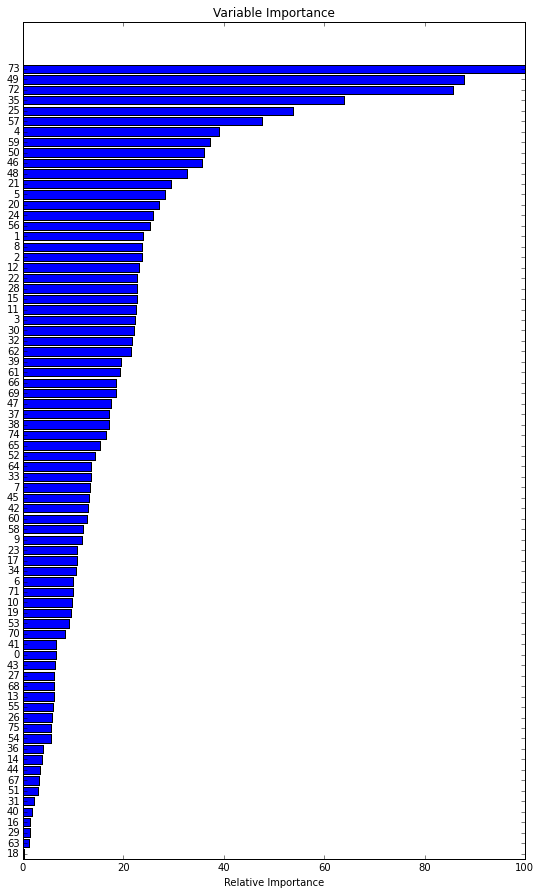

In [102]:
# Plot feature importance
feature_importance = et.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(9,15))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, sorted_idx)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

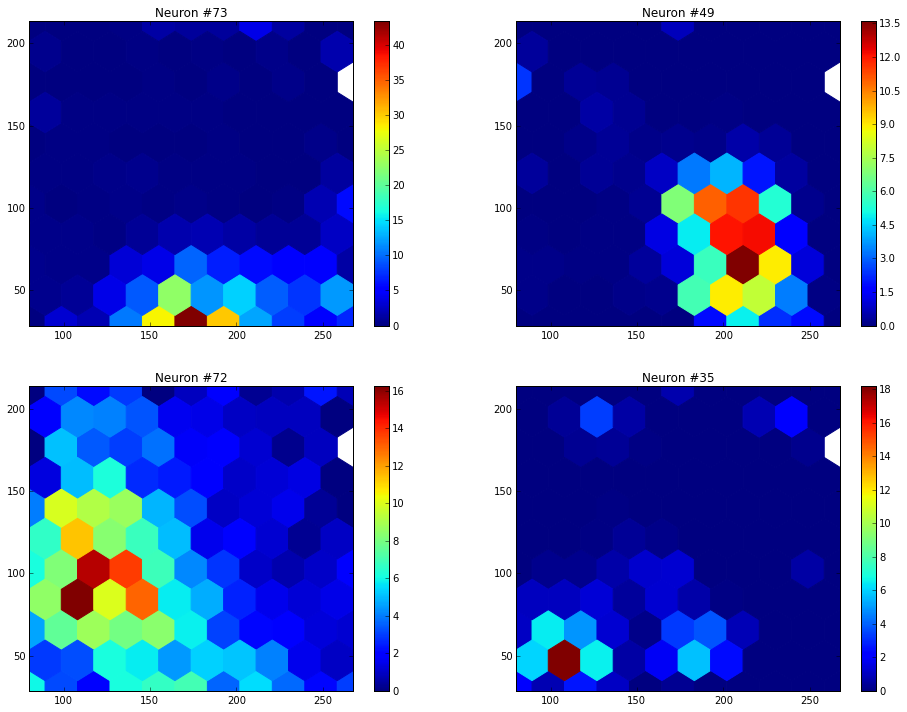

In [123]:
plt.figure(figsize=(16,12))
for i in xrange(1,5):
    plt.subplot(2,2,i)
    plt.hexbin(position[...,0], position[...,1], features[...,sorted_idx[-i]], gridsize = 10)
    plt.colorbar()
    plt.title("Neuron #%d" % sorted_idx[-i])

# Gradient Boosted Regression Trees

## First try defaults

Clearly underfits.

In [81]:
from sklearn.ensemble import GradientBoostingRegressor
gb = (GradientBoostingRegressor(), GradientBoostingRegressor())
gb[0].fit(train_X, train_Y[...,0])
gb[1].fit(train_X, train_Y[...,1])

train_pred_Y = np.hstack((gb[0].predict(train_X)[:,np.newaxis], gb[1].predict(train_X)[:,np.newaxis]))
test_pred_Y = np.hstack((gb[0].predict(test_X)[:,np.newaxis], gb[1].predict(test_X)[:,np.newaxis]))

print "Train mean distance %f, test mean distance: %f, test R^2 score %f" % \
    (mean_distance(train_pred_Y, train_Y), mean_distance(test_pred_Y, test_Y), 
     (gb[0].score(test_X, test_Y[...,0]) + gb[1].score(test_X,  test_Y[...,1])) / 2)

Train mean distance 30.989945, test mean distance: 31.639049, test R^2 score 0.597813


## Try different numbers of trees

More trees improves result, above 1000 the improvement is negligible.

In [80]:
for n in [500, 1000, 2000]:
    gb = (GradientBoostingRegressor(n_estimators = n), GradientBoostingRegressor(n_estimators = n))
    gb[0].fit(train_X, train_Y[...,0])
    gb[1].fit(train_X, train_Y[...,1])

    train_pred_Y = np.hstack((gb[0].predict(train_X)[:,np.newaxis], gb[1].predict(train_X)[:,np.newaxis]))
    test_pred_Y = np.hstack((gb[0].predict(test_X)[:,np.newaxis], gb[1].predict(test_X)[:,np.newaxis]))

    print "Train mean distance %f, test mean distance: %f, test R^2 score %f" % \
        (mean_distance(train_pred_Y, train_Y), mean_distance(test_pred_Y, test_Y), 
         (gb[0].score(test_X, test_Y[...,0]) + gb[1].score(test_X,  test_Y[...,1])) / 2)

Train mean distance 30.989945, test mean distance: 31.644235, test R^2 score 0.597545
Train mean distance 20.348536, test mean distance: 28.379120, test R^2 score 0.672186
Train mean distance 16.280129, test mean distance: 28.076208, test R^2 score 0.678566


## Try different tree depths

In [83]:
gb = (GradientBoostingRegressor(n_estimators = 1000, max_depth = 10), 
      GradientBoostingRegressor(n_estimators = 1000, max_depth = 10))
gb[0].fit(train_X, train_Y[...,0])
gb[1].fit(train_X, train_Y[...,1])

train_pred_Y = np.hstack((gb[0].predict(train_X)[:,np.newaxis], gb[1].predict(train_X)[:,np.newaxis]))
test_pred_Y = np.hstack((gb[0].predict(test_X)[:,np.newaxis], gb[1].predict(test_X)[:,np.newaxis]))

print "Train mean distance %f, test mean distance: %f, test R^2 score %f" % \
    (mean_distance(train_pred_Y, train_Y), mean_distance(test_pred_Y, test_Y), 
     (gb[0].score(test_X, test_Y[...,0]) + gb[1].score(test_X,  test_Y[...,1])) / 2)

Train mean distance 0.169983, test mean distance: 25.672324, test R^2 score 0.705540


KeyboardInterrupt: 

In [ ]:
# Plot feature importance
feature_importance = gb[0].feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

# Support Vector Regression

In [17]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_X_scaled = scaler.fit_transform(train_X.astype('float'))
test_X_scaled = scaler.transform(test_X.astype('float'))

In [21]:
from sklearn.svm import SVR
gb = (SVR(), SVR())
gb[0].fit(train_X_scaled, train_Y[...,0])
gb[1].fit(train_X_scaled, train_Y[...,1])

train_pred_Y = np.hstack((gb[0].predict(train_X_scaled)[:,np.newaxis], gb[1].predict(train_X_scaled)[:,np.newaxis]))
test_pred_Y = np.hstack((gb[0].predict(test_X_scaled)[:,np.newaxis], gb[1].predict(test_X_scaled)[:,np.newaxis]))

print "Train mean distance %f, test mean distance: %f, test R^2 score %f" % \
    (mean_distance(train_pred_Y, train_Y), mean_distance(test_pred_Y, test_Y), 
     (gb[0].score(test_X_scaled, test_Y[...,0]) + gb[1].score(test_X_scaled,  test_Y[...,1])) / 2)

Train mean distance 37.141808, test mean distance: 35.219719, test R^2 score 0.488361


In [31]:
for c in [200, 500, 1000]:
    gb = (SVR(C = c), SVR(C = c))
    gb[0].fit(train_X_scaled, train_Y[...,0])
    gb[1].fit(train_X_scaled, train_Y[...,1])

    train_pred_Y = np.hstack((gb[0].predict(train_X_scaled)[:,np.newaxis], gb[1].predict(train_X_scaled)[:,np.newaxis]))
    test_pred_Y = np.hstack((gb[0].predict(test_X_scaled)[:,np.newaxis], gb[1].predict(test_X_scaled)[:,np.newaxis]))

    print "Train mean distance %f, test mean distance: %f, test R^2 score %f" % \
        (mean_distance(train_pred_Y, train_Y), mean_distance(test_pred_Y, test_Y), 
         (gb[0].score(test_X_scaled, test_Y[...,0]) + gb[1].score(test_X_scaled,  test_Y[...,1])) / 2)

Train mean distance 8.783312, test mean distance: 26.714180, test R^2 score 0.683542
Train mean distance 6.055590, test mean distance: 27.560173, test R^2 score 0.670514
Train mean distance 4.442352, test mean distance: 28.475286, test R^2 score 0.655295


In [18]:
from sklearn.svm import SVR

for kernel in ['linear', 'poly', 'sigmoid']:
    gb = (SVR(kernel = kernel), SVR(kernel = kernel))
    gb[0].fit(train_X_scaled, train_Y[...,0])
    gb[1].fit(train_X_scaled, train_Y[...,1])

    train_pred_Y = np.hstack((gb[0].predict(train_X_scaled)[:,np.newaxis], gb[1].predict(train_X_scaled)[:,np.newaxis]))
    test_pred_Y = np.hstack((gb[0].predict(test_X_scaled)[:,np.newaxis], gb[1].predict(test_X_scaled)[:,np.newaxis]))

    print "Train mean distance %f, test mean distance: %f, test R^2 score %f" % \
        (mean_distance(train_pred_Y, train_Y), mean_distance(test_pred_Y, test_Y), 
         (gb[0].score(test_X_scaled, test_Y[...,0]) + gb[1].score(test_X_scaled,  test_Y[...,1])) / 2)


Train mean distance 38.417961, test mean distance: 36.065710, test R^2 score 0.481370
Train mean distance 44.983832, test mean distance: 46.908203, test R^2 score 0.203605
Train mean distance 58.233199, test mean distance: 56.345678, test R^2 score -0.033250


In [19]:
from sklearn.grid_search import GridSearchCV

tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

cvx = GridSearchCV(SVR(), tuned_parameters, cv=5, verbose=1)
cvx.fit(train_X_scaled, train_Y[...,0])
print cvx.best_params_, cvx.best_score_

cvy = GridSearchCV(SVR(), tuned_parameters, cv=5, verbose=1)
cvy.fit(train_X_scaled, train_Y[...,1])
print cvy.best_params_, cvy.best_score_

train_pred_Y = np.hstack((cvx.predict(train_X_scaled)[:,np.newaxis], cvy.predict(train_X_scaled)[:,np.newaxis]))
test_pred_Y = np.hstack((cvx.predict(test_X_scaled)[:,np.newaxis], cvy.predict(test_X_scaled)[:,np.newaxis]))

print "Train mean distance %f, test mean distance: %f, test R^2 score %f" % \
    (mean_distance(train_pred_Y, train_Y), mean_distance(test_pred_Y, test_Y), 
     (cvx.score(test_X_scaled, test_Y[...,0]) + cvy.score(test_X_scaled,  test_Y[...,1])) / 2)

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:   13.7s
[Parallel(n_jobs=1)]: Done  50 jobs       | elapsed: 13.3min


Fitting 5 folds for each of 12 candidates, totalling 60 fits
{'kernel': 'rbf', 'C': 1000, 'gamma': 0.001}

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 182.1min finished
[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:   13.2s
[Parallel(n_jobs=1)]: Done  50 jobs       | elapsed: 13.1min
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 186.0min finished


 0.541538553381
Fitting 5 folds for each of 12 candidates, totalling 60 fits
{'kernel': 'rbf', 'C': 1000, 'gamma': 0.001} 0.590260786003
Train mean distance 23.724048, test mean distance: 28.819474, test R^2 score 0.650158


In [25]:
from sklearn.svm import LinearSVR
ls = (LinearSVR(), LinearSVR())
ls[0].fit(train_X_scaled, train_Y[...,0])
ls[1].fit(train_X_scaled, train_Y[...,1])

import numpy as np

train_pred_Y = np.hstack((ls[0].predict(train_X_scaled)[:,np.newaxis], ls[1].predict(train_X_scaled)[:,np.newaxis]))
test_pred_Y = np.hstack((ls[0].predict(test_X_scaled)[:,np.newaxis], ls[1].predict(test_X_scaled)[:,np.newaxis]))

print "Train mean distance %f, test mean distance: %f, test R^2 score %f" % \
    (mean_distance(train_pred_Y, train_Y), mean_distance(test_pred_Y, test_Y), 
     (ls[0].score(test_X_scaled, test_Y[...,0]) + ls[1].score(test_X_scaled,  test_Y[...,1])) / 2)

Train mean distance 38.445282, test mean distance: 36.074008, test R^2 score 0.480593


In [28]:
from sklearn.svm import LinearSVR
for c in [0.1, 1, 10, 100]:
    ls = (LinearSVR(C = c), LinearSVR(C = c))
    ls[0].fit(train_X_scaled, train_Y[...,0])
    ls[1].fit(train_X_scaled, train_Y[...,1])

    train_pred_Y = np.hstack((ls[0].predict(train_X_scaled)[:,np.newaxis], ls[1].predict(train_X_scaled)[:,np.newaxis]))
    test_pred_Y = np.hstack((ls[0].predict(test_X_scaled)[:,np.newaxis], ls[1].predict(test_X_scaled)[:,np.newaxis]))

    print "Train mean distance %f, test mean distance: %f, test R^2 score %f" % \
        (mean_distance(train_pred_Y, train_Y), mean_distance(test_pred_Y, test_Y), 
         (ls[0].score(test_X_scaled, test_Y[...,0]) + ls[1].score(test_X_scaled,  test_Y[...,1])) / 2)

Train mean distance 39.298119, test mean distance: 36.761039, test R^2 score 0.461514
Train mean distance 38.444020, test mean distance: 36.056495, test R^2 score 0.481160
Train mean distance 38.438369, test mean distance: 36.095187, test R^2 score 0.480074
Train mean distance 39.086596, test mean distance: 36.434098, test R^2 score 0.473765


# KNN Regression

In [7]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor()
knn.fit(train_X, train_Y)
train_pred_Y = knn.predict(train_X)
test_pred_Y = knn.predict(test_X)

import numpy as np

print "Train mean distance %f, test mean distance: %f, test R^2 score %f" % \
    (mean_distance(train_pred_Y, train_Y), mean_distance(test_pred_Y, test_Y), knn.score(test_X, test_Y))

Train mean distance 22.689570, test mean distance: 39.464479, test R^2 score 0.317359


In [9]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.grid_search import GridSearchCV

tuned_parameters = [{'n_neighbors': [1, 5, 10], 'weights': ['uniform', 'distance']}]

cv = GridSearchCV(KNeighborsRegressor(), tuned_parameters, cv=5, verbose=1)
cv.fit(train_X, train_Y)
train_pred_Y = cv.predict(train_X)
test_pred_Y = cv.predict(test_X)

print "Train mean distance %f, test mean distance: %f, test R^2 score %f" % \
    (mean_distance(train_pred_Y, train_Y), mean_distance(test_pred_Y, test_Y), cv.score(test_X, test_Y))

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  1.2min finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits
Train mean distance 0.000000, test mean distance: 39.261042, test R^2 score 0.362834


In [10]:
print cv.best_params_, cv.best_score_

{'n_neighbors': 10, 'weights': 'distance'} 0.249695655591


In [11]:
print cv.grid_scores_ 

[mean: -0.23633, std: 0.11236, params: {'n_neighbors': 1, 'weights': 'uniform'}, mean: -0.23633, std: 0.11236, params: {'n_neighbors': 1, 'weights': 'distance'}, mean: 0.20031, std: 0.02534, params: {'n_neighbors': 5, 'weights': 'uniform'}, mean: 0.20454, std: 0.02515, params: {'n_neighbors': 5, 'weights': 'distance'}, mean: 0.24427, std: 0.01862, params: {'n_neighbors': 10, 'weights': 'uniform'}, mean: 0.24970, std: 0.01869, params: {'n_neighbors': 10, 'weights': 'distance'}]
